### **Optimal Balanced Matching**

This refers to a new form of matching used in observational studies that aims to achieve two goals:
1. match similar patients in each pair
2. create balanced treated and control groups in aggregate

Specifically, Optimal Balanced Matching involves:

**Risk set matching**: When a patient receives treatment at time t, they are matched to another patient with a similar history of symptoms up to time t who has not received the treatment up to time t.

**Balancing**: Using a penalty function in integer programming to force the marginal distributions of symptoms to be balanced in the matched treated and control groups.

**Optimization**: Among all balanced matchings, selecting the one that minimizes the multivariate pretreatment covariate distance within matched pairs.

***Steps***

1. **Define the Pool**: Identify the group of patients you're working with, those who received the treatment, and the possible pairings between treated and untreated individuals.

2. **Define Covariates**: Select a set of K binary variables that describe the covariates to be balanced.

3. **Assess Similarity**: Determine how to measure the distance/similarity between potential matches. Mahalanobis distance is a common choice.

4. **Balance the Groups**: Use a penalty function within an integer programming framework to force the marginal distributions of the covariates to be balanced in the matched treated and control groups.

5. **Optimize the Matching**: Use minimum cost flow in a network to find the optimal matching that minimizes the total distance within pairs while satisfying the balance requirements.

### **Hungarian Algorithm**

The Hungarian algorithm is **a combinatorial optimization algorithm that solves the assignment problem in polynomial time**. It is used to find the optimal assignment of tasks to agents (or, in this case, treated patients to untreated patients) such that the total cost (or distance) is minimized.

> ***How does it work?***
>
> **Cost Matrix**: A matrix is created where each row represents a treated patient, each column represents an untreated patient, and each cell contains the cost (or distance) of matching that treated patient to that untreated patient.
>
>**Row and Column Reduction**: Subtract the smallest value in each row from all elements in that row. Subtract the smallest value in each column from all elements in that column.
>
>**Covering Zeros**: Find the minimum number of lines (rows or columns) needed to cover all zeros in the matrix.
>
>**Optimal Assignment**: If the number of lines equals the number of rows (or columns), an optimal assignment exists. Otherwise, adjust the matrix and repeat the process.
>
>**Result**: The algorithm returns the optimal assignment of treated patients to untreated patients that minimizes the total cost.

In the context of this journal's Optimal Balance Matching, the algorithm is used as the following:

1. **Match Treated and Untreated Patients**: Each treated patient is matched to an untreated patient based on their symptom scores (e.g., Pain_Score, Urgency_Score, Frequency_Score).

2. **Minimize Total Distance**: The algorithm ensures that the total Euclidean distance between matched pairs is minimized.

3. **Ensure One-to-One Matching**: Each treated patient is matched to exactly one untreated patient, and vice versa.

In [ ]:
pip install scipy

In [ ]:
pip install scikit-learn

In [ ]:
pip install seaborn

:: OPTIMIZED MATCHED PAIRS
      Treated_ID  Treated_Pain_Score  Treated_Urgency_Score  \
0      Patient_1                   3                      4   
1      Patient_5                   3                      4   
2      Patient_6                   1                      4   
3      Patient_7                   9                      5   
4     Patient_11                   2                      4   
..           ...                 ...                    ...   
139  Patient_292                   5                      3   
140  Patient_294                  10                      9   
141  Patient_295                   0                      8   
142  Patient_298                   8                      7   
143  Patient_300                   0                      7   

     Treated_Frequency_Score Treated_Treatment_Time Untreated_ID  \
0                          2    2025-02-10 20:26:56  Patient_197   
1                          0    2025-02-10 05:26:39   Patient_44   
2           

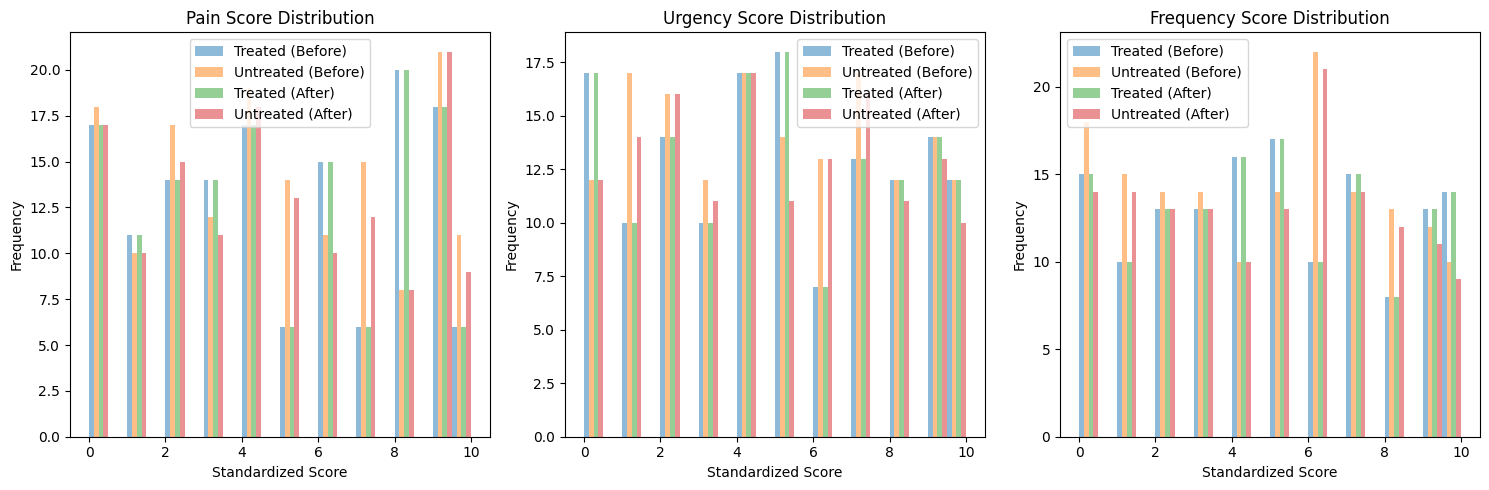

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import linear_sum_assignment
from sklearn.preprocessing import StandardScaler

# Load dataset (if not already loaded)
df = pd.read_csv('../Datasets/patient_treatment_data.csv')

# Convert Treatment_Time to datetime
df['Treatment_Time'] = pd.to_datetime(df['Treatment_Time'])

# Separate treated and untreated patients
treated = df[df['Treated'] == 'Yes']
untreated = df[df['Treated'] == 'No']

# Define the symptom columns to match on
symptom_columns = ['Pain_Score', 'Urgency_Score', 'Frequency_Score']

# Standardize the symptom scores for distance calculation
scaler = StandardScaler()
df[symptom_columns] = scaler.fit_transform(df[symptom_columns])

# Function to calculate Euclidean distance
def euclidean_distance(row1, row2, columns):
    return np.sqrt(np.sum((row1[columns] - row2[columns]) ** 2))

# Function to perform optimal balanced matching
def optimal_balanced_matching(treated, untreated, symptom_columns):
    # Create a cost matrix
    cost_matrix = np.zeros((len(treated), len(untreated)))
    
    # Calculate pairwise distances
    for i in range(len(treated)):
        for j in range(len(untreated)):
            treated_patient = treated.iloc[i]
            untreated_patient = untreated.iloc[j]
            cost_matrix[i, j] = euclidean_distance(treated_patient, untreated_patient, symptom_columns)
    
    # Use the Hungarian algorithm to find the optimal matching
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    
    # Create the optimized matched pairs
    optimized_matches = []
    for i, j in zip(row_ind, col_ind):
        treated_patient = treated.iloc[i]
        untreated_patient = untreated.iloc[j]
        optimized_matches.append({
            'Treated_ID': treated_patient['ID'],
            'Treated_Pain_Score': treated_patient['Pain_Score'],
            'Treated_Urgency_Score': treated_patient['Urgency_Score'],
            'Treated_Frequency_Score': treated_patient['Frequency_Score'],
            'Treated_Treatment_Time': treated_patient['Treatment_Time'],
            'Untreated_ID': untreated_patient['ID'],
            'Untreated_Pain_Score': untreated_patient['Pain_Score'],
            'Untreated_Urgency_Score': untreated_patient['Urgency_Score'],
            'Untreated_Frequency_Score': untreated_patient['Frequency_Score'],
            'Untreated_Treatment_Time': untreated_patient['Treatment_Time']
        })
    
    return pd.DataFrame(optimized_matches)

# Perform optimal balanced matching
optimized_matched_pairs = optimal_balanced_matching(treated, untreated, symptom_columns)

# Display the optimized matched pairs
print(":: OPTIMIZED MATCHED PAIRS")
print(optimized_matched_pairs)

# Visualization: Compare distributions before and after matching using histograms
plt.figure(figsize=(15, 5))

# Plot Pain_Score distribution
plt.subplot(1, 3, 1)
plt.hist([treated['Pain_Score'], untreated['Pain_Score'], optimized_matched_pairs['Treated_Pain_Score'], optimized_matched_pairs['Untreated_Pain_Score']], 
         bins=20, alpha=0.5, label=['Treated (Before)', 'Untreated (Before)', 'Treated (After)', 'Untreated (After)'], rwidth=1.0)
plt.title('Pain Score Distribution')
plt.xlabel('Standardized Score')
plt.ylabel('Frequency')
plt.legend()

# Plot Urgency_Score distribution
plt.subplot(1, 3, 2)
plt.hist([treated['Urgency_Score'], untreated['Urgency_Score'], optimized_matched_pairs['Treated_Urgency_Score'], optimized_matched_pairs['Untreated_Urgency_Score']], 
         bins=20, alpha=0.5, label=['Treated (Before)', 'Untreated (Before)', 'Treated (After)', 'Untreated (After)'], rwidth=1.0)
plt.title('Urgency Score Distribution')
plt.xlabel('Standardized Score')
plt.ylabel('Frequency')
plt.legend()

# Plot Frequency_Score distribution
plt.subplot(1, 3, 3)
plt.hist([treated['Frequency_Score'], untreated['Frequency_Score'], optimized_matched_pairs['Treated_Frequency_Score'], optimized_matched_pairs['Untreated_Frequency_Score']], 
         bins=20, alpha=0.5, label=['Treated (Before)', 'Untreated (Before)', 'Treated (After)', 'Untreated (After)'], rwidth=1.0)
plt.title('Frequency Score Distribution')
plt.xlabel('Standardized Score')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()